# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

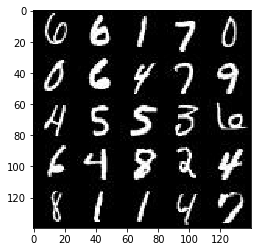

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

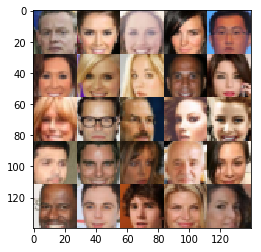

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images=tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name='input_images')
    z_tensor=tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name='z_tensor')
    learning_rate=tf.placeholder(dtype=tf.float32,name='learning_rate')
    return  input_images, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,alpha=0.07 ,dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1=tf.maximum(alpha*x1,x1)
        x2=tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn1=tf.layers.batch_normalization(x2,training=True)
        relu2=tf.maximum(alpha*bn1,bn1)
        x3=tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(x3,training=True)
        relu3=tf.maximum(alpha*bn2,bn2)
        flat=tf.reshape(relu3,(-1,4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits=tf.layers.dense(dropout_layer, 1)
        out=tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x1=tf.layers.dense(z,(3*3*512))
        x1=tf.reshape(x1,(-1,3,3,512))
        bn1=tf.layers.batch_normalization(x1,training=is_train)
        relu1=tf.maximum(alpha*bn1,bn1)
        x2=tf.layers.conv2d_transpose(relu1,256,4,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(x2,training=is_train)
        relu2=tf.maximum(alpha*bn2,bn2)
        x3=tf.layers.conv2d_transpose(relu2,128,4,strides=2,padding='valid')
        bn2=tf.layers.batch_normalization(x3,training=is_train)
        relu3=tf.maximum(alpha*bn2,bn2)
        logits=tf.layers.conv2d_transpose(relu3,out_channel_dim, kernel_size=5,strides=2,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2,dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim,is_train=True,alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real,dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)) )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [i for i in t_vars if i.name.startswith('discriminator')]
    g_vars = [i for i in t_vars if i.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    # TODO: Build Model
    alpha = 0.2
    n_samples, image_width, image_height, image_channels = data_shape
    input_images, z_tensor, l_r=model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss=model_loss(input_images, z_tensor, image_channels,alpha=alpha)
    d_train_opt, g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    print_loss_every = 10
    show_image_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_images: batch_images, z_tensor: batch_z, l_r:learning_rate})
                sess.run(g_train_opt, feed_dict={input_images: batch_images, z_tensor: batch_z, l_r:learning_rate})
                
                
                if step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({z_tensor: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % show_image_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, z_tensor, image_channels, data_image_mode)
                    


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.4678... Generator Loss: 2.5837
Epoch 0/2... Discriminator Loss: 0.5581... Generator Loss: 5.0520
Epoch 0/2... Discriminator Loss: 2.0558... Generator Loss: 0.2508
Epoch 0/2... Discriminator Loss: 1.0996... Generator Loss: 0.7347
Epoch 0/2... Discriminator Loss: 1.7626... Generator Loss: 8.8288


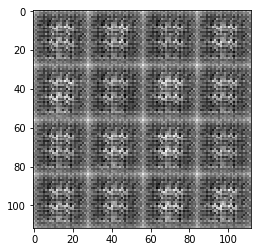

Epoch 0/2... Discriminator Loss: 0.7207... Generator Loss: 2.8567
Epoch 0/2... Discriminator Loss: 0.5994... Generator Loss: 3.4662
Epoch 0/2... Discriminator Loss: 0.4808... Generator Loss: 2.7737
Epoch 0/2... Discriminator Loss: 0.4611... Generator Loss: 3.0075
Epoch 0/2... Discriminator Loss: 0.9722... Generator Loss: 0.9191


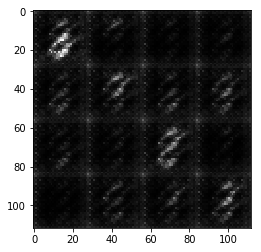

Epoch 0/2... Discriminator Loss: 0.5660... Generator Loss: 2.5212
Epoch 0/2... Discriminator Loss: 0.5134... Generator Loss: 2.5671
Epoch 0/2... Discriminator Loss: 0.5589... Generator Loss: 2.2533
Epoch 0/2... Discriminator Loss: 0.6012... Generator Loss: 2.0915
Epoch 0/2... Discriminator Loss: 0.6902... Generator Loss: 1.9562


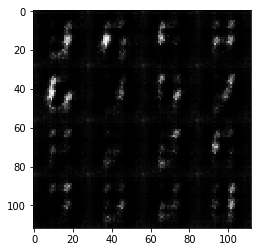

Epoch 0/2... Discriminator Loss: 0.6842... Generator Loss: 2.1965
Epoch 0/2... Discriminator Loss: 0.6411... Generator Loss: 3.0889
Epoch 0/2... Discriminator Loss: 0.6644... Generator Loss: 1.8523
Epoch 0/2... Discriminator Loss: 0.7445... Generator Loss: 3.0635
Epoch 0/2... Discriminator Loss: 0.4632... Generator Loss: 3.2307


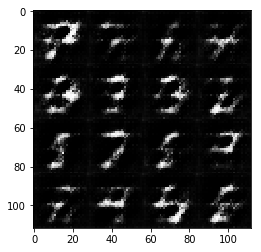

Epoch 0/2... Discriminator Loss: 1.2833... Generator Loss: 1.0551
Epoch 0/2... Discriminator Loss: 0.8719... Generator Loss: 2.0409
Epoch 0/2... Discriminator Loss: 0.7152... Generator Loss: 1.7883
Epoch 0/2... Discriminator Loss: 0.7799... Generator Loss: 1.5511
Epoch 0/2... Discriminator Loss: 0.7364... Generator Loss: 1.6119


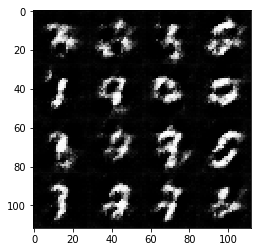

Epoch 0/2... Discriminator Loss: 0.8064... Generator Loss: 2.6113
Epoch 0/2... Discriminator Loss: 0.6561... Generator Loss: 2.9079
Epoch 0/2... Discriminator Loss: 0.7079... Generator Loss: 1.8272
Epoch 0/2... Discriminator Loss: 0.9555... Generator Loss: 1.0647
Epoch 0/2... Discriminator Loss: 0.7734... Generator Loss: 1.4428


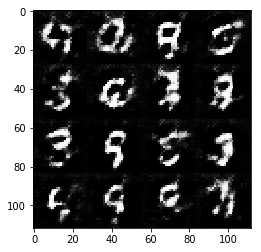

Epoch 0/2... Discriminator Loss: 0.7475... Generator Loss: 1.8921
Epoch 0/2... Discriminator Loss: 0.8704... Generator Loss: 1.3028
Epoch 0/2... Discriminator Loss: 0.7730... Generator Loss: 1.7386
Epoch 0/2... Discriminator Loss: 1.0982... Generator Loss: 0.8561
Epoch 0/2... Discriminator Loss: 0.7052... Generator Loss: 1.9127


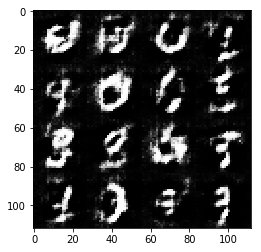

Epoch 0/2... Discriminator Loss: 1.0835... Generator Loss: 0.8203
Epoch 0/2... Discriminator Loss: 0.7624... Generator Loss: 1.8480
Epoch 0/2... Discriminator Loss: 1.0083... Generator Loss: 0.9910
Epoch 0/2... Discriminator Loss: 0.9523... Generator Loss: 2.8248
Epoch 0/2... Discriminator Loss: 0.6929... Generator Loss: 1.7673


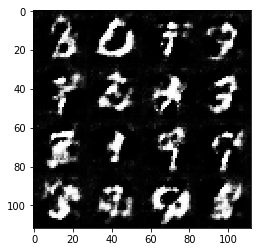

Epoch 0/2... Discriminator Loss: 0.9687... Generator Loss: 3.0394
Epoch 0/2... Discriminator Loss: 0.8022... Generator Loss: 2.7130
Epoch 0/2... Discriminator Loss: 0.7859... Generator Loss: 2.7331
Epoch 0/2... Discriminator Loss: 0.8973... Generator Loss: 1.1007
Epoch 0/2... Discriminator Loss: 0.9890... Generator Loss: 0.9716


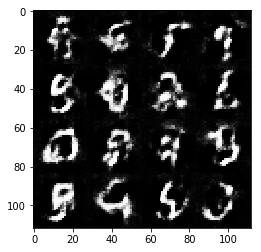

Epoch 0/2... Discriminator Loss: 0.7308... Generator Loss: 1.5847
Epoch 0/2... Discriminator Loss: 0.7206... Generator Loss: 2.1519
Epoch 0/2... Discriminator Loss: 0.6879... Generator Loss: 1.7990
Epoch 0/2... Discriminator Loss: 0.8296... Generator Loss: 2.2430
Epoch 0/2... Discriminator Loss: 0.7348... Generator Loss: 2.0958


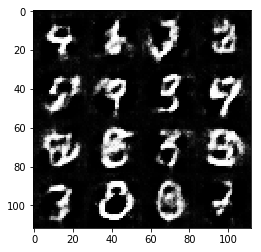

Epoch 0/2... Discriminator Loss: 0.6823... Generator Loss: 1.8979
Epoch 0/2... Discriminator Loss: 0.7943... Generator Loss: 1.5801
Epoch 0/2... Discriminator Loss: 0.7248... Generator Loss: 1.4960
Epoch 0/2... Discriminator Loss: 0.7506... Generator Loss: 1.4017
Epoch 0/2... Discriminator Loss: 1.2692... Generator Loss: 3.5294


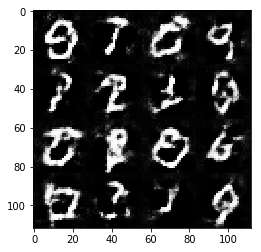

Epoch 0/2... Discriminator Loss: 0.6888... Generator Loss: 1.7643
Epoch 0/2... Discriminator Loss: 0.6671... Generator Loss: 2.0936
Epoch 0/2... Discriminator Loss: 1.1740... Generator Loss: 2.6865
Epoch 0/2... Discriminator Loss: 0.7496... Generator Loss: 1.3764
Epoch 0/2... Discriminator Loss: 0.8061... Generator Loss: 2.1092


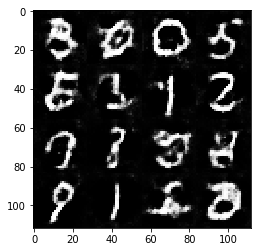

Epoch 0/2... Discriminator Loss: 1.0085... Generator Loss: 0.9429
Epoch 0/2... Discriminator Loss: 0.9455... Generator Loss: 2.1750
Epoch 0/2... Discriminator Loss: 0.9237... Generator Loss: 1.0473
Epoch 0/2... Discriminator Loss: 1.3935... Generator Loss: 0.5324
Epoch 0/2... Discriminator Loss: 0.7229... Generator Loss: 1.6356


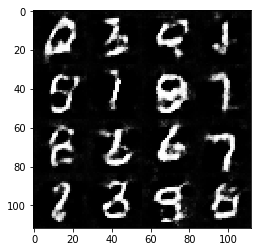

Epoch 0/2... Discriminator Loss: 0.7556... Generator Loss: 1.5227
Epoch 0/2... Discriminator Loss: 0.8337... Generator Loss: 1.1557
Epoch 0/2... Discriminator Loss: 1.1981... Generator Loss: 0.6836
Epoch 0/2... Discriminator Loss: 0.8385... Generator Loss: 1.2105
Epoch 0/2... Discriminator Loss: 0.8679... Generator Loss: 1.1746


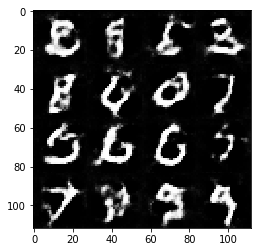

Epoch 0/2... Discriminator Loss: 0.8079... Generator Loss: 1.8394
Epoch 0/2... Discriminator Loss: 0.7495... Generator Loss: 2.1982
Epoch 0/2... Discriminator Loss: 0.9396... Generator Loss: 0.9903
Epoch 0/2... Discriminator Loss: 0.8249... Generator Loss: 1.2101
Epoch 0/2... Discriminator Loss: 0.7570... Generator Loss: 2.3115


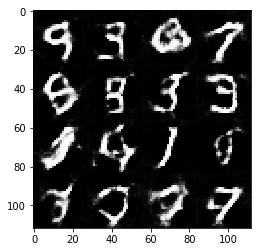

Epoch 0/2... Discriminator Loss: 0.7422... Generator Loss: 1.9115
Epoch 0/2... Discriminator Loss: 0.8886... Generator Loss: 1.0744
Epoch 0/2... Discriminator Loss: 0.9299... Generator Loss: 0.9967
Epoch 0/2... Discriminator Loss: 0.7069... Generator Loss: 1.9737
Epoch 0/2... Discriminator Loss: 0.8660... Generator Loss: 2.1332


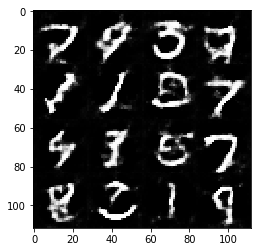

Epoch 0/2... Discriminator Loss: 0.8924... Generator Loss: 1.0413
Epoch 0/2... Discriminator Loss: 0.8793... Generator Loss: 1.1180
Epoch 0/2... Discriminator Loss: 0.7252... Generator Loss: 1.5745
Epoch 0/2... Discriminator Loss: 0.9078... Generator Loss: 0.9896
Epoch 0/2... Discriminator Loss: 1.0832... Generator Loss: 2.5498


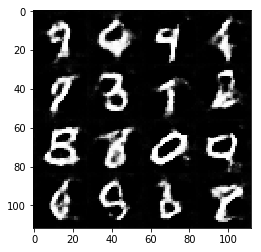

Epoch 0/2... Discriminator Loss: 0.7582... Generator Loss: 2.0332
Epoch 0/2... Discriminator Loss: 0.8559... Generator Loss: 1.0927
Epoch 0/2... Discriminator Loss: 0.8556... Generator Loss: 1.1090
Epoch 0/2... Discriminator Loss: 0.8758... Generator Loss: 2.2704
Epoch 0/2... Discriminator Loss: 1.1253... Generator Loss: 0.7393


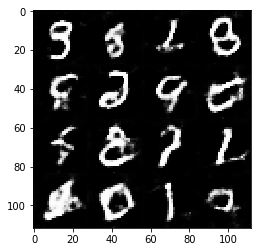

Epoch 0/2... Discriminator Loss: 0.8435... Generator Loss: 1.1835
Epoch 0/2... Discriminator Loss: 0.8183... Generator Loss: 1.3964
Epoch 0/2... Discriminator Loss: 1.1776... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 1.4402
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.5555


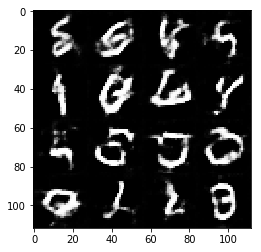

Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 2.2562


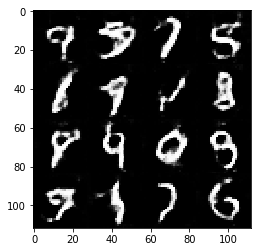

Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 2.7980
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 2.1199
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 1.7309


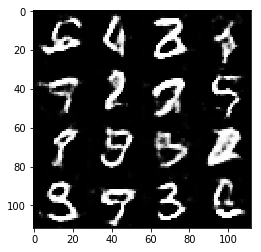

Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.4990
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.5365
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.3849


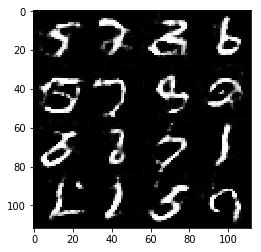

Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 0.7011... Generator Loss: 1.5391
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 2.7009
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 2.9849
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 1.3201


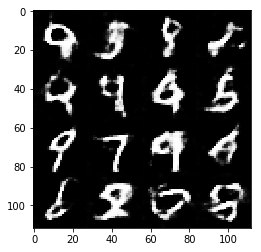

Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.1196
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.5407


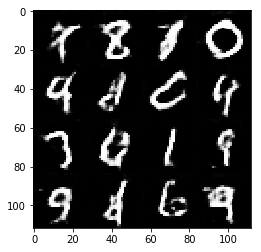

Epoch 1/2... Discriminator Loss: 0.7612... Generator Loss: 1.3484
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 1.6876
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.3879
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.3533


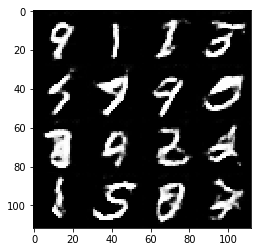

Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 1.6878
Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 1.3581
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.4119


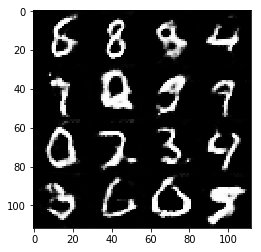

Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 0.6926... Generator Loss: 1.5177
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 2.8732
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 3.0540


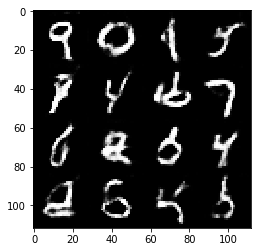

Epoch 1/2... Discriminator Loss: 0.6538... Generator Loss: 1.5467
Epoch 1/2... Discriminator Loss: 0.6878... Generator Loss: 1.4276
Epoch 1/2... Discriminator Loss: 0.7282... Generator Loss: 1.2928
Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 2.0397
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 2.1325


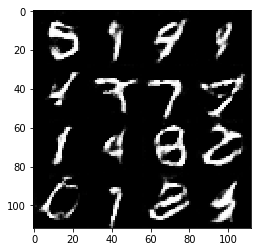

Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.4809
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 1.8133
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.6483
Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 1.3726


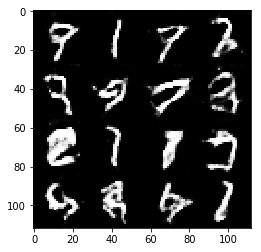

Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 1.6701
Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 1.5694
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 0.9939
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 2.1592
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.0656


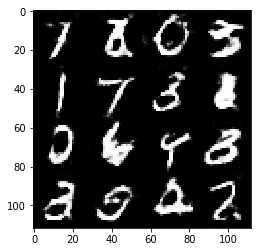

Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 1.5034
Epoch 1/2... Discriminator Loss: 0.6605... Generator Loss: 1.6708
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.4590
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.2565
Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.3829


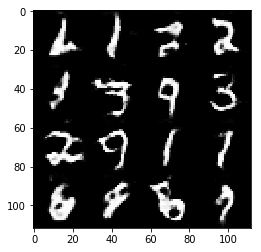

Epoch 1/2... Discriminator Loss: 0.7188... Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 0.4306
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 1.6399


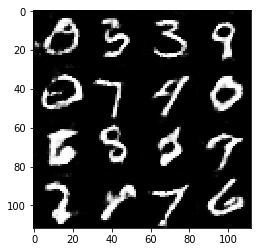

Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 1.8158
Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.3550


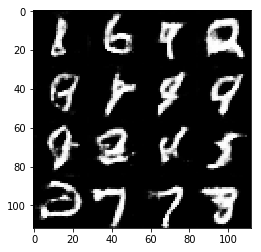

Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 0.6725... Generator Loss: 2.1690
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 1.6869
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 1.1431


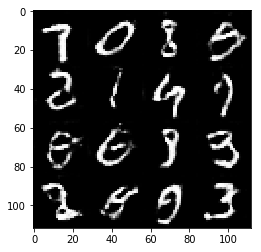

Epoch 1/2... Discriminator Loss: 0.8615... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.2912
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 2.0255
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.5273


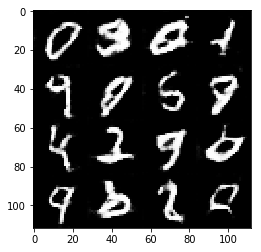

Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 2.9993
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 2.1047
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 2.0230


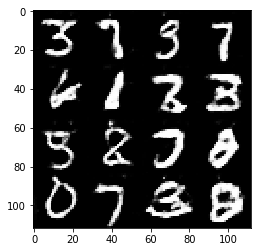

Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 2.1819
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.7302
Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 2.8085
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 1.7399
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.4450


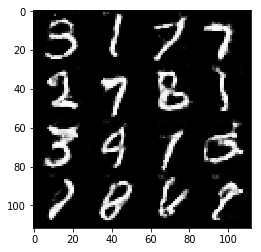

Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.7355


In [15]:
batch_size =64
z_dim =100
learning_rate =.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.9692... Generator Loss: 0.1129
Epoch 0/1... Discriminator Loss: 1.5842... Generator Loss: 0.5428
Epoch 0/1... Discriminator Loss: 1.2677... Generator Loss: 0.7608
Epoch 0/1... Discriminator Loss: 1.1198... Generator Loss: 0.7838
Epoch 0/1... Discriminator Loss: 1.5819... Generator Loss: 8.7082


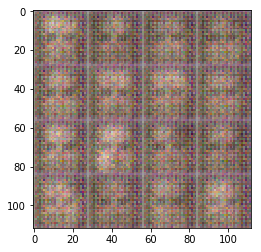

Epoch 0/1... Discriminator Loss: 1.8629... Generator Loss: 0.3415
Epoch 0/1... Discriminator Loss: 1.0470... Generator Loss: 1.2411
Epoch 0/1... Discriminator Loss: 1.0940... Generator Loss: 1.5364
Epoch 0/1... Discriminator Loss: 1.0372... Generator Loss: 1.6850
Epoch 0/1... Discriminator Loss: 0.8623... Generator Loss: 2.0201


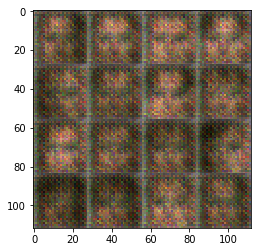

Epoch 0/1... Discriminator Loss: 1.5528... Generator Loss: 0.4291
Epoch 0/1... Discriminator Loss: 1.0673... Generator Loss: 0.7734
Epoch 0/1... Discriminator Loss: 1.0197... Generator Loss: 0.9538
Epoch 0/1... Discriminator Loss: 1.9743... Generator Loss: 0.2988
Epoch 0/1... Discriminator Loss: 1.1906... Generator Loss: 0.7076


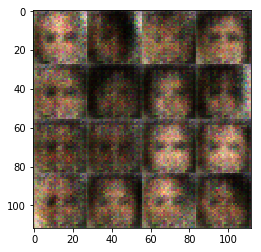

Epoch 0/1... Discriminator Loss: 0.7793... Generator Loss: 1.8015
Epoch 0/1... Discriminator Loss: 0.8710... Generator Loss: 1.8269
Epoch 0/1... Discriminator Loss: 0.9080... Generator Loss: 1.0693
Epoch 0/1... Discriminator Loss: 0.9412... Generator Loss: 1.4713
Epoch 0/1... Discriminator Loss: 0.8860... Generator Loss: 1.0717


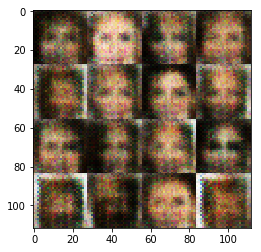

Epoch 0/1... Discriminator Loss: 1.4629... Generator Loss: 0.4823
Epoch 0/1... Discriminator Loss: 1.7519... Generator Loss: 0.3303
Epoch 0/1... Discriminator Loss: 0.7261... Generator Loss: 1.9234
Epoch 0/1... Discriminator Loss: 1.3023... Generator Loss: 0.6359
Epoch 0/1... Discriminator Loss: 0.8827... Generator Loss: 1.1069


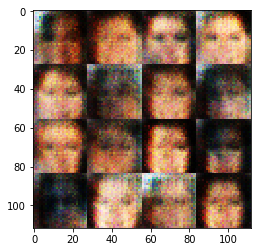

Epoch 0/1... Discriminator Loss: 0.8071... Generator Loss: 1.3383
Epoch 0/1... Discriminator Loss: 1.6425... Generator Loss: 0.4392
Epoch 0/1... Discriminator Loss: 2.0311... Generator Loss: 0.2588
Epoch 0/1... Discriminator Loss: 0.9755... Generator Loss: 0.9597
Epoch 0/1... Discriminator Loss: 0.8529... Generator Loss: 1.2820


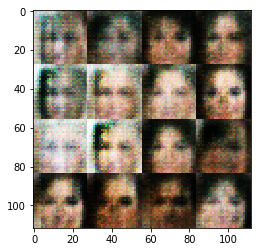

Epoch 0/1... Discriminator Loss: 0.8536... Generator Loss: 1.0436
Epoch 0/1... Discriminator Loss: 1.1449... Generator Loss: 0.7099
Epoch 0/1... Discriminator Loss: 0.9332... Generator Loss: 3.4135
Epoch 0/1... Discriminator Loss: 0.7814... Generator Loss: 2.9333
Epoch 0/1... Discriminator Loss: 1.7437... Generator Loss: 0.3793


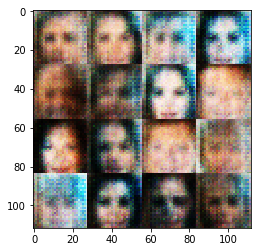

Epoch 0/1... Discriminator Loss: 0.8249... Generator Loss: 1.2993
Epoch 0/1... Discriminator Loss: 1.7631... Generator Loss: 0.3921
Epoch 0/1... Discriminator Loss: 0.8449... Generator Loss: 1.2449
Epoch 0/1... Discriminator Loss: 1.1661... Generator Loss: 0.7050
Epoch 0/1... Discriminator Loss: 1.8033... Generator Loss: 0.3402


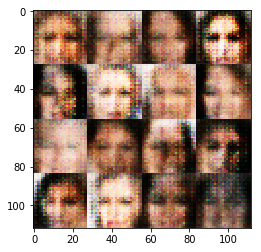

Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 2.4328
Epoch 0/1... Discriminator Loss: 1.3450... Generator Loss: 0.6187
Epoch 0/1... Discriminator Loss: 0.9684... Generator Loss: 1.0084
Epoch 0/1... Discriminator Loss: 1.4715... Generator Loss: 0.4319
Epoch 0/1... Discriminator Loss: 0.7226... Generator Loss: 1.8206


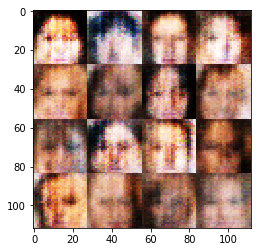

Epoch 0/1... Discriminator Loss: 0.9782... Generator Loss: 1.3769
Epoch 0/1... Discriminator Loss: 0.7675... Generator Loss: 1.8520
Epoch 0/1... Discriminator Loss: 1.1656... Generator Loss: 2.7555
Epoch 0/1... Discriminator Loss: 0.7897... Generator Loss: 1.3318
Epoch 0/1... Discriminator Loss: 1.4489... Generator Loss: 3.0324


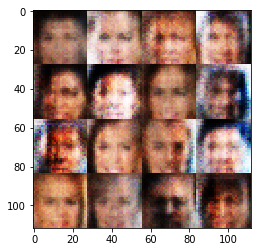

Epoch 0/1... Discriminator Loss: 0.7811... Generator Loss: 1.4001
Epoch 0/1... Discriminator Loss: 0.7925... Generator Loss: 1.4749
Epoch 0/1... Discriminator Loss: 1.0539... Generator Loss: 0.8559
Epoch 0/1... Discriminator Loss: 0.9236... Generator Loss: 1.0152
Epoch 0/1... Discriminator Loss: 0.9416... Generator Loss: 1.6230


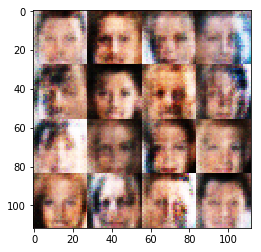

Epoch 0/1... Discriminator Loss: 1.0799... Generator Loss: 0.7428
Epoch 0/1... Discriminator Loss: 1.2331... Generator Loss: 0.5896
Epoch 0/1... Discriminator Loss: 1.4260... Generator Loss: 0.4744
Epoch 0/1... Discriminator Loss: 0.9319... Generator Loss: 0.9805
Epoch 0/1... Discriminator Loss: 1.3143... Generator Loss: 0.6248


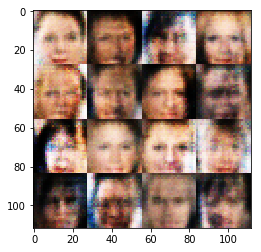

Epoch 0/1... Discriminator Loss: 0.8087... Generator Loss: 2.1408
Epoch 0/1... Discriminator Loss: 0.9741... Generator Loss: 0.9979
Epoch 0/1... Discriminator Loss: 1.2482... Generator Loss: 0.5938
Epoch 0/1... Discriminator Loss: 0.8560... Generator Loss: 1.9045
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.7601


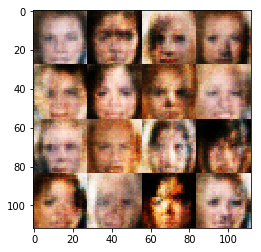

Epoch 0/1... Discriminator Loss: 1.0199... Generator Loss: 0.8228
Epoch 0/1... Discriminator Loss: 1.7201... Generator Loss: 0.3346
Epoch 0/1... Discriminator Loss: 1.3026... Generator Loss: 0.5470
Epoch 0/1... Discriminator Loss: 1.1138... Generator Loss: 2.3508
Epoch 0/1... Discriminator Loss: 0.9025... Generator Loss: 1.7415


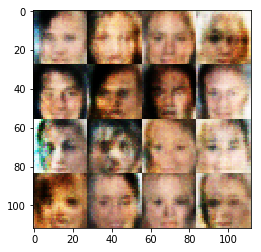

Epoch 0/1... Discriminator Loss: 1.0860... Generator Loss: 0.8816
Epoch 0/1... Discriminator Loss: 0.7326... Generator Loss: 1.4538
Epoch 0/1... Discriminator Loss: 0.9483... Generator Loss: 2.4105
Epoch 0/1... Discriminator Loss: 0.7630... Generator Loss: 1.8288
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 1.1429


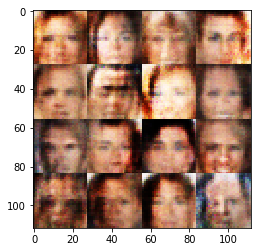

Epoch 0/1... Discriminator Loss: 1.3588... Generator Loss: 0.5856
Epoch 0/1... Discriminator Loss: 1.1518... Generator Loss: 1.8060
Epoch 0/1... Discriminator Loss: 0.9291... Generator Loss: 1.0515
Epoch 0/1... Discriminator Loss: 1.4506... Generator Loss: 0.5097
Epoch 0/1... Discriminator Loss: 0.9358... Generator Loss: 1.0280


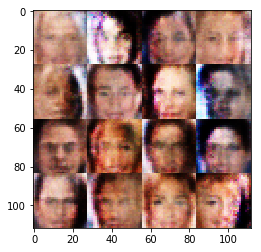

Epoch 0/1... Discriminator Loss: 0.9248... Generator Loss: 1.0465
Epoch 0/1... Discriminator Loss: 0.9333... Generator Loss: 1.3250
Epoch 0/1... Discriminator Loss: 1.1397... Generator Loss: 0.8392
Epoch 0/1... Discriminator Loss: 0.8813... Generator Loss: 1.1163
Epoch 0/1... Discriminator Loss: 0.9298... Generator Loss: 1.0912


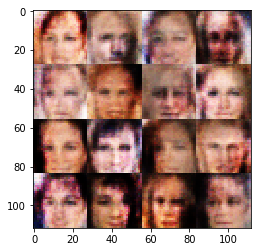

Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 1.3138
Epoch 0/1... Discriminator Loss: 1.0581... Generator Loss: 1.8036
Epoch 0/1... Discriminator Loss: 0.9637... Generator Loss: 0.9970
Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 0.8583
Epoch 0/1... Discriminator Loss: 1.1014... Generator Loss: 0.7377


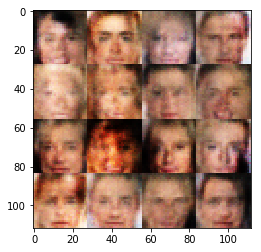

Epoch 0/1... Discriminator Loss: 0.8155... Generator Loss: 1.2611
Epoch 0/1... Discriminator Loss: 1.1402... Generator Loss: 0.6999
Epoch 0/1... Discriminator Loss: 1.6255... Generator Loss: 2.4760
Epoch 0/1... Discriminator Loss: 0.9223... Generator Loss: 1.6351
Epoch 0/1... Discriminator Loss: 0.7686... Generator Loss: 1.7894


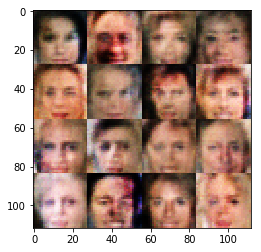

Epoch 0/1... Discriminator Loss: 2.0090... Generator Loss: 2.6971
Epoch 0/1... Discriminator Loss: 1.1730... Generator Loss: 0.6911
Epoch 0/1... Discriminator Loss: 1.4058... Generator Loss: 0.4735
Epoch 0/1... Discriminator Loss: 1.4620... Generator Loss: 0.4286
Epoch 0/1... Discriminator Loss: 1.2160... Generator Loss: 0.6360


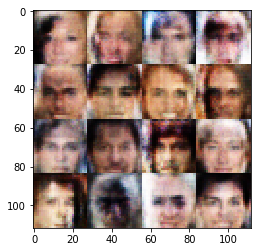

Epoch 0/1... Discriminator Loss: 1.0275... Generator Loss: 0.9091
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.8610
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 0.5395
Epoch 0/1... Discriminator Loss: 1.3651... Generator Loss: 0.4923
Epoch 0/1... Discriminator Loss: 1.0116... Generator Loss: 1.7756


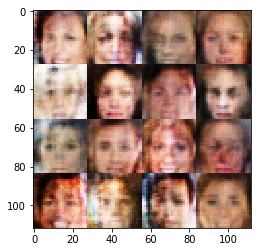

Epoch 0/1... Discriminator Loss: 1.0762... Generator Loss: 1.9323
Epoch 0/1... Discriminator Loss: 0.9371... Generator Loss: 0.9665
Epoch 0/1... Discriminator Loss: 1.7295... Generator Loss: 0.3351
Epoch 0/1... Discriminator Loss: 1.0188... Generator Loss: 1.8160
Epoch 0/1... Discriminator Loss: 1.2518... Generator Loss: 0.5784


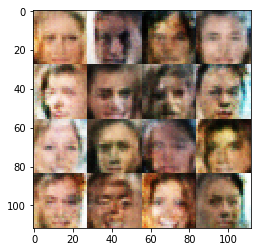

Epoch 0/1... Discriminator Loss: 0.9263... Generator Loss: 2.1395
Epoch 0/1... Discriminator Loss: 1.3185... Generator Loss: 0.5399
Epoch 0/1... Discriminator Loss: 0.8997... Generator Loss: 1.7975
Epoch 0/1... Discriminator Loss: 0.9522... Generator Loss: 1.4063
Epoch 0/1... Discriminator Loss: 1.6913... Generator Loss: 0.3242


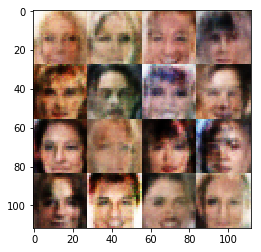

Epoch 0/1... Discriminator Loss: 0.9346... Generator Loss: 1.7386
Epoch 0/1... Discriminator Loss: 0.7424... Generator Loss: 2.2357
Epoch 0/1... Discriminator Loss: 0.9203... Generator Loss: 1.2374
Epoch 0/1... Discriminator Loss: 0.9296... Generator Loss: 1.7354
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 0.7115


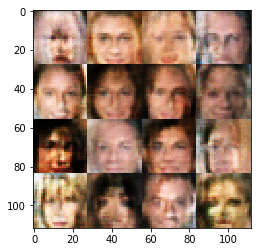

Epoch 0/1... Discriminator Loss: 1.3136... Generator Loss: 0.5576
Epoch 0/1... Discriminator Loss: 1.5523... Generator Loss: 0.3912
Epoch 0/1... Discriminator Loss: 0.9647... Generator Loss: 1.7579
Epoch 0/1... Discriminator Loss: 1.0469... Generator Loss: 0.9390
Epoch 0/1... Discriminator Loss: 2.1263... Generator Loss: 0.2118


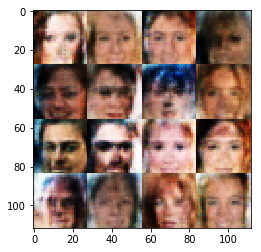

Epoch 0/1... Discriminator Loss: 1.0019... Generator Loss: 1.1342
Epoch 0/1... Discriminator Loss: 1.4339... Generator Loss: 0.4713
Epoch 0/1... Discriminator Loss: 1.2535... Generator Loss: 0.6128
Epoch 0/1... Discriminator Loss: 1.8845... Generator Loss: 0.2740
Epoch 0/1... Discriminator Loss: 1.0003... Generator Loss: 0.9218


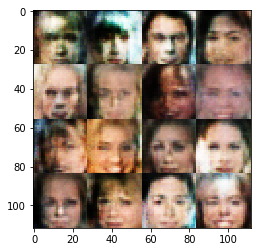

Epoch 0/1... Discriminator Loss: 0.9043... Generator Loss: 1.0560
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 2.9033
Epoch 0/1... Discriminator Loss: 1.4352... Generator Loss: 0.4598
Epoch 0/1... Discriminator Loss: 1.3849... Generator Loss: 0.5022
Epoch 0/1... Discriminator Loss: 1.1955... Generator Loss: 0.6312


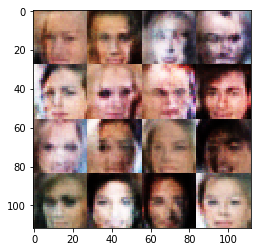

Epoch 0/1... Discriminator Loss: 1.2615... Generator Loss: 0.5838
Epoch 0/1... Discriminator Loss: 1.1648... Generator Loss: 0.6394
Epoch 0/1... Discriminator Loss: 0.8388... Generator Loss: 1.5404
Epoch 0/1... Discriminator Loss: 0.7873... Generator Loss: 1.4008
Epoch 0/1... Discriminator Loss: 1.3013... Generator Loss: 0.5146


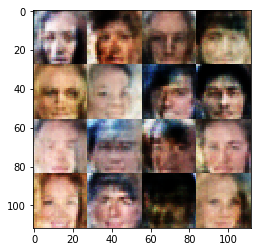

Epoch 0/1... Discriminator Loss: 0.8859... Generator Loss: 1.5064
Epoch 0/1... Discriminator Loss: 0.8278... Generator Loss: 1.4526
Epoch 0/1... Discriminator Loss: 1.0434... Generator Loss: 1.9658
Epoch 0/1... Discriminator Loss: 0.8629... Generator Loss: 2.2522
Epoch 0/1... Discriminator Loss: 2.4422... Generator Loss: 0.1570


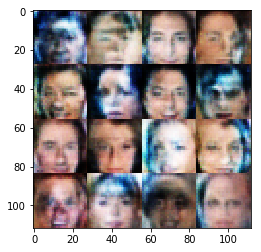

Epoch 0/1... Discriminator Loss: 0.8871... Generator Loss: 2.7204
Epoch 0/1... Discriminator Loss: 1.5729... Generator Loss: 0.4093
Epoch 0/1... Discriminator Loss: 1.1331... Generator Loss: 1.3577
Epoch 0/1... Discriminator Loss: 0.8997... Generator Loss: 0.9877
Epoch 0/1... Discriminator Loss: 1.2666... Generator Loss: 1.2110


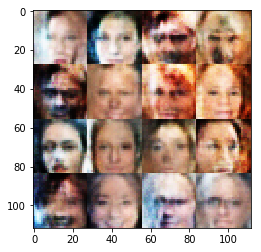

Epoch 0/1... Discriminator Loss: 1.3871... Generator Loss: 0.5033
Epoch 0/1... Discriminator Loss: 1.2728... Generator Loss: 1.5266
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 0.8839
Epoch 0/1... Discriminator Loss: 1.0072... Generator Loss: 2.9551
Epoch 0/1... Discriminator Loss: 2.2537... Generator Loss: 0.1896


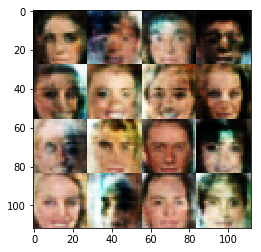

Epoch 0/1... Discriminator Loss: 0.8154... Generator Loss: 1.7797
Epoch 0/1... Discriminator Loss: 1.1622... Generator Loss: 2.0562
Epoch 0/1... Discriminator Loss: 1.6459... Generator Loss: 0.3582
Epoch 0/1... Discriminator Loss: 0.9050... Generator Loss: 0.9409
Epoch 0/1... Discriminator Loss: 0.8132... Generator Loss: 1.3767


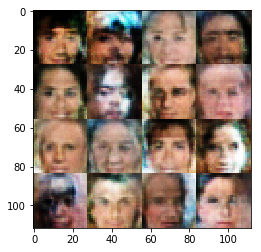

Epoch 0/1... Discriminator Loss: 1.9745... Generator Loss: 0.2746
Epoch 0/1... Discriminator Loss: 0.8297... Generator Loss: 1.0922
Epoch 0/1... Discriminator Loss: 1.3090... Generator Loss: 0.5735
Epoch 0/1... Discriminator Loss: 1.4312... Generator Loss: 0.4404
Epoch 0/1... Discriminator Loss: 1.4681... Generator Loss: 0.4774


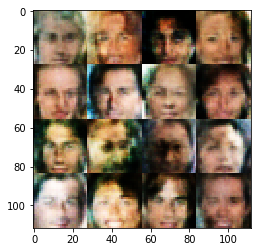

Epoch 0/1... Discriminator Loss: 1.5146... Generator Loss: 0.4258
Epoch 0/1... Discriminator Loss: 0.9010... Generator Loss: 1.6520
Epoch 0/1... Discriminator Loss: 0.8298... Generator Loss: 3.1568
Epoch 0/1... Discriminator Loss: 0.6831... Generator Loss: 1.6721
Epoch 0/1... Discriminator Loss: 1.1699... Generator Loss: 3.2108


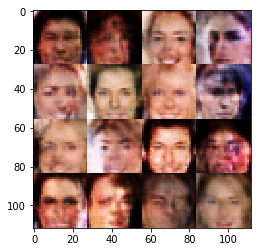

Epoch 0/1... Discriminator Loss: 1.1783... Generator Loss: 0.7266
Epoch 0/1... Discriminator Loss: 1.7963... Generator Loss: 0.2890
Epoch 0/1... Discriminator Loss: 1.7178... Generator Loss: 0.3266
Epoch 0/1... Discriminator Loss: 1.6277... Generator Loss: 0.3663
Epoch 0/1... Discriminator Loss: 1.0399... Generator Loss: 0.7815


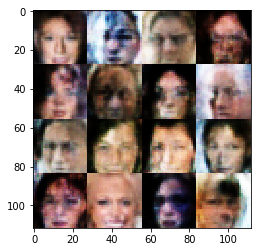

Epoch 0/1... Discriminator Loss: 0.7084... Generator Loss: 1.4979
Epoch 0/1... Discriminator Loss: 1.0371... Generator Loss: 0.8109
Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.5744
Epoch 0/1... Discriminator Loss: 1.0804... Generator Loss: 0.7416
Epoch 0/1... Discriminator Loss: 0.6054... Generator Loss: 1.6749


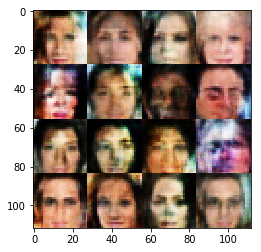

Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 0.7242
Epoch 0/1... Discriminator Loss: 1.7413... Generator Loss: 3.6323
Epoch 0/1... Discriminator Loss: 1.6720... Generator Loss: 0.3733
Epoch 0/1... Discriminator Loss: 0.7920... Generator Loss: 1.1939
Epoch 0/1... Discriminator Loss: 0.7000... Generator Loss: 1.3798


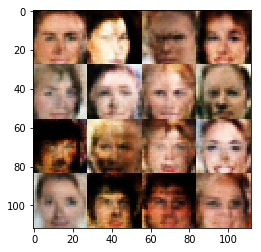

Epoch 0/1... Discriminator Loss: 0.8626... Generator Loss: 1.9700
Epoch 0/1... Discriminator Loss: 1.1123... Generator Loss: 0.7237
Epoch 0/1... Discriminator Loss: 1.7486... Generator Loss: 0.3042
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 2.3177
Epoch 0/1... Discriminator Loss: 0.6902... Generator Loss: 2.5660


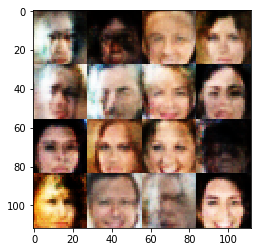

Epoch 0/1... Discriminator Loss: 0.6493... Generator Loss: 2.6470
Epoch 0/1... Discriminator Loss: 1.5451... Generator Loss: 0.4006
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 0.8401
Epoch 0/1... Discriminator Loss: 0.7849... Generator Loss: 1.1290
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 0.8082


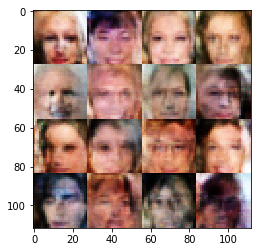

Epoch 0/1... Discriminator Loss: 1.0249... Generator Loss: 0.7876
Epoch 0/1... Discriminator Loss: 1.2934... Generator Loss: 0.5914
Epoch 0/1... Discriminator Loss: 1.2131... Generator Loss: 0.6186
Epoch 0/1... Discriminator Loss: 2.0156... Generator Loss: 0.2782
Epoch 0/1... Discriminator Loss: 0.9335... Generator Loss: 1.7214


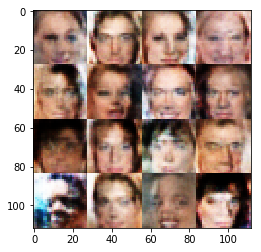

Epoch 0/1... Discriminator Loss: 0.7106... Generator Loss: 1.2801
Epoch 0/1... Discriminator Loss: 1.7596... Generator Loss: 0.3159
Epoch 0/1... Discriminator Loss: 0.7640... Generator Loss: 1.1494
Epoch 0/1... Discriminator Loss: 0.6710... Generator Loss: 2.7372
Epoch 0/1... Discriminator Loss: 0.7207... Generator Loss: 1.3975


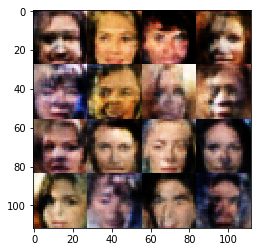

Epoch 0/1... Discriminator Loss: 0.6159... Generator Loss: 2.0072
Epoch 0/1... Discriminator Loss: 0.6119... Generator Loss: 2.0462
Epoch 0/1... Discriminator Loss: 0.6242... Generator Loss: 1.8011
Epoch 0/1... Discriminator Loss: 0.7121... Generator Loss: 1.3609
Epoch 0/1... Discriminator Loss: 0.8420... Generator Loss: 3.5051


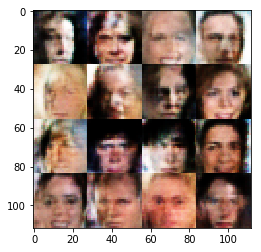

Epoch 0/1... Discriminator Loss: 0.4763... Generator Loss: 2.6994
Epoch 0/1... Discriminator Loss: 1.6320... Generator Loss: 2.7626
Epoch 0/1... Discriminator Loss: 0.5652... Generator Loss: 1.9953
Epoch 0/1... Discriminator Loss: 1.0853... Generator Loss: 0.7021
Epoch 0/1... Discriminator Loss: 0.6904... Generator Loss: 1.3272


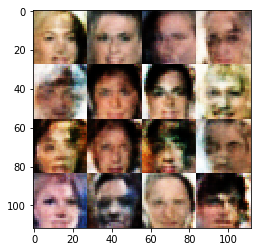

Epoch 0/1... Discriminator Loss: 0.6301... Generator Loss: 2.9011
Epoch 0/1... Discriminator Loss: 0.7096... Generator Loss: 1.3202
Epoch 0/1... Discriminator Loss: 1.5600... Generator Loss: 0.3940
Epoch 0/1... Discriminator Loss: 0.9115... Generator Loss: 0.9974
Epoch 0/1... Discriminator Loss: 1.0734... Generator Loss: 0.7329


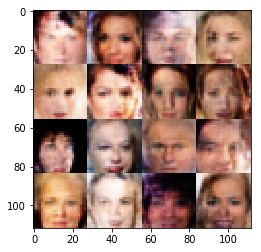

Epoch 0/1... Discriminator Loss: 0.6749... Generator Loss: 1.3803
Epoch 0/1... Discriminator Loss: 0.4782... Generator Loss: 2.6315
Epoch 0/1... Discriminator Loss: 0.8375... Generator Loss: 2.3988
Epoch 0/1... Discriminator Loss: 0.5824... Generator Loss: 2.5278
Epoch 0/1... Discriminator Loss: 0.5468... Generator Loss: 1.8007


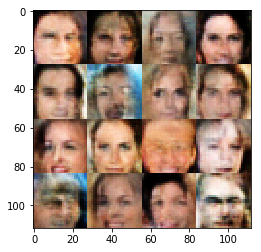

Epoch 0/1... Discriminator Loss: 0.4869... Generator Loss: 2.1674
Epoch 0/1... Discriminator Loss: 0.9903... Generator Loss: 0.8170
Epoch 0/1... Discriminator Loss: 0.5083... Generator Loss: 2.3987
Epoch 0/1... Discriminator Loss: 0.7080... Generator Loss: 3.5445
Epoch 0/1... Discriminator Loss: 0.5700... Generator Loss: 2.5745


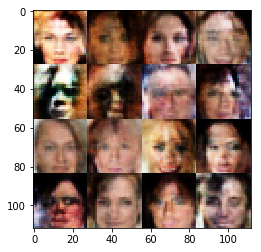

Epoch 0/1... Discriminator Loss: 0.8355... Generator Loss: 2.2459
Epoch 0/1... Discriminator Loss: 0.5872... Generator Loss: 1.8350
Epoch 0/1... Discriminator Loss: 0.8702... Generator Loss: 1.1163
Epoch 0/1... Discriminator Loss: 0.5793... Generator Loss: 3.1046
Epoch 0/1... Discriminator Loss: 1.0275... Generator Loss: 3.6141


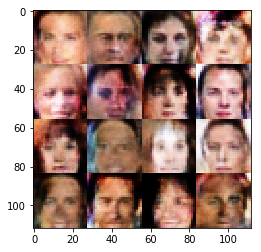

Epoch 0/1... Discriminator Loss: 0.5103... Generator Loss: 2.2135
Epoch 0/1... Discriminator Loss: 0.7034... Generator Loss: 3.5666
Epoch 0/1... Discriminator Loss: 0.9092... Generator Loss: 2.5317
Epoch 0/1... Discriminator Loss: 0.9524... Generator Loss: 0.8985
Epoch 0/1... Discriminator Loss: 1.4999... Generator Loss: 4.1129


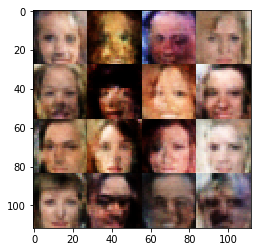

Epoch 0/1... Discriminator Loss: 0.4931... Generator Loss: 2.1136
Epoch 0/1... Discriminator Loss: 2.0536... Generator Loss: 0.2297
Epoch 0/1... Discriminator Loss: 0.8596... Generator Loss: 1.0795
Epoch 0/1... Discriminator Loss: 1.2254... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 1.2854... Generator Loss: 0.5565


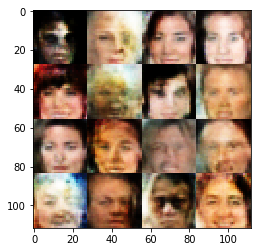

Epoch 0/1... Discriminator Loss: 0.7481... Generator Loss: 2.2470
Epoch 0/1... Discriminator Loss: 0.7568... Generator Loss: 1.2128
Epoch 0/1... Discriminator Loss: 0.5504... Generator Loss: 1.7493
Epoch 0/1... Discriminator Loss: 0.7305... Generator Loss: 1.6815
Epoch 0/1... Discriminator Loss: 0.5438... Generator Loss: 1.9609


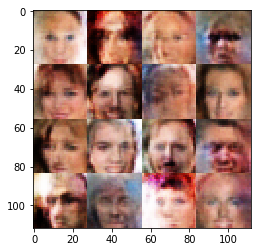

Epoch 0/1... Discriminator Loss: 0.4645... Generator Loss: 3.1317
Epoch 0/1... Discriminator Loss: 0.8670... Generator Loss: 3.4461
Epoch 0/1... Discriminator Loss: 1.0521... Generator Loss: 4.0148
Epoch 0/1... Discriminator Loss: 0.8879... Generator Loss: 0.9624
Epoch 0/1... Discriminator Loss: 0.7867... Generator Loss: 2.3083


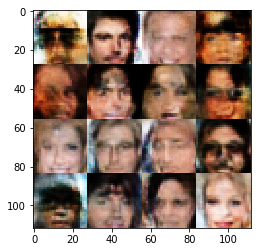

Epoch 0/1... Discriminator Loss: 0.7439... Generator Loss: 3.5589
Epoch 0/1... Discriminator Loss: 0.6427... Generator Loss: 1.5338
Epoch 0/1... Discriminator Loss: 0.7748... Generator Loss: 1.4323
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 0.9577
Epoch 0/1... Discriminator Loss: 2.0090... Generator Loss: 0.3859


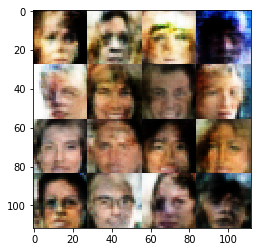

Epoch 0/1... Discriminator Loss: 1.8564... Generator Loss: 0.3103
Epoch 0/1... Discriminator Loss: 1.0298... Generator Loss: 0.8668
Epoch 0/1... Discriminator Loss: 0.5095... Generator Loss: 2.8480
Epoch 0/1... Discriminator Loss: 0.9814... Generator Loss: 0.9202
Epoch 0/1... Discriminator Loss: 1.0491... Generator Loss: 0.7984


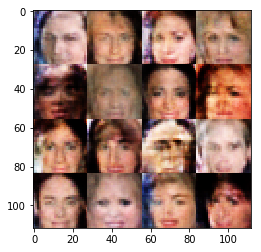

Epoch 0/1... Discriminator Loss: 0.7860... Generator Loss: 2.7800
Epoch 0/1... Discriminator Loss: 0.5237... Generator Loss: 2.6755
Epoch 0/1... Discriminator Loss: 0.9142... Generator Loss: 3.7163
Epoch 0/1... Discriminator Loss: 0.5717... Generator Loss: 2.0363
Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.6834


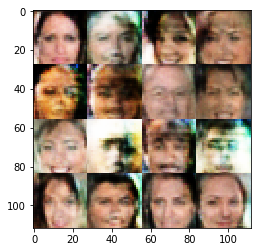

Epoch 0/1... Discriminator Loss: 0.5940... Generator Loss: 2.8767
Epoch 0/1... Discriminator Loss: 1.0075... Generator Loss: 0.8055
Epoch 0/1... Discriminator Loss: 0.7144... Generator Loss: 3.4143
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 2.4705
Epoch 0/1... Discriminator Loss: 0.5697... Generator Loss: 2.8337


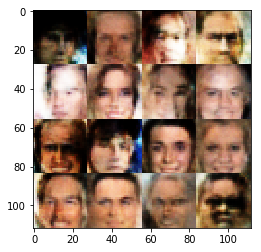

Epoch 0/1... Discriminator Loss: 0.9424... Generator Loss: 0.8764
Epoch 0/1... Discriminator Loss: 1.0080... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 0.7588... Generator Loss: 1.2360
Epoch 0/1... Discriminator Loss: 0.7326... Generator Loss: 2.3605
Epoch 0/1... Discriminator Loss: 0.8747... Generator Loss: 1.2255


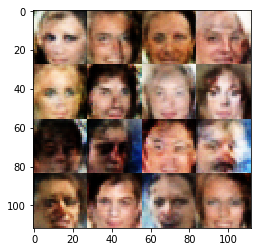

Epoch 0/1... Discriminator Loss: 0.7424... Generator Loss: 2.4748
Epoch 0/1... Discriminator Loss: 0.8410... Generator Loss: 1.4427
Epoch 0/1... Discriminator Loss: 0.9232... Generator Loss: 2.6603
Epoch 0/1... Discriminator Loss: 0.9780... Generator Loss: 0.8443
Epoch 0/1... Discriminator Loss: 0.6140... Generator Loss: 1.7185


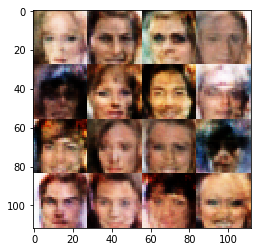

Epoch 0/1... Discriminator Loss: 0.6929... Generator Loss: 1.5827
Epoch 0/1... Discriminator Loss: 0.4719... Generator Loss: 2.4507
Epoch 0/1... Discriminator Loss: 0.6647... Generator Loss: 2.2839
Epoch 0/1... Discriminator Loss: 0.6206... Generator Loss: 2.8474
Epoch 0/1... Discriminator Loss: 0.4429... Generator Loss: 2.6156


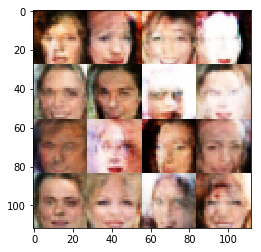

Epoch 0/1... Discriminator Loss: 3.0247... Generator Loss: 3.9446
Epoch 0/1... Discriminator Loss: 0.8032... Generator Loss: 2.5720
Epoch 0/1... Discriminator Loss: 0.6415... Generator Loss: 1.8053
Epoch 0/1... Discriminator Loss: 0.6115... Generator Loss: 1.6781
Epoch 0/1... Discriminator Loss: 0.6659... Generator Loss: 3.0218


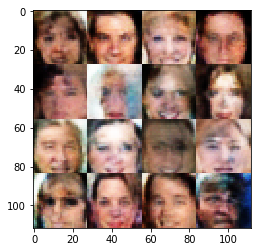

Epoch 0/1... Discriminator Loss: 0.7613... Generator Loss: 1.8978
Epoch 0/1... Discriminator Loss: 1.1178... Generator Loss: 0.7385
Epoch 0/1... Discriminator Loss: 0.4072... Generator Loss: 3.0934
Epoch 0/1... Discriminator Loss: 0.5002... Generator Loss: 2.2701
Epoch 0/1... Discriminator Loss: 0.4957... Generator Loss: 2.3247


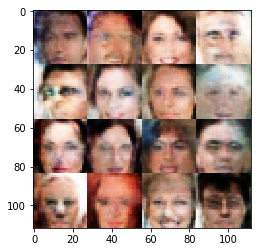

Epoch 0/1... Discriminator Loss: 0.5364... Generator Loss: 2.2718
Epoch 0/1... Discriminator Loss: 0.5009... Generator Loss: 2.9049
Epoch 0/1... Discriminator Loss: 0.4264... Generator Loss: 2.7992
Epoch 0/1... Discriminator Loss: 0.5728... Generator Loss: 1.7282
Epoch 0/1... Discriminator Loss: 0.4902... Generator Loss: 2.1241


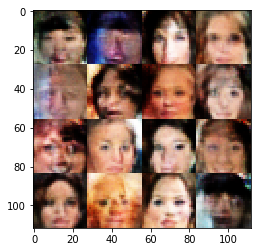

Epoch 0/1... Discriminator Loss: 0.5433... Generator Loss: 2.8175
Epoch 0/1... Discriminator Loss: 0.7485... Generator Loss: 1.2499
Epoch 0/1... Discriminator Loss: 3.7320... Generator Loss: 0.0518
Epoch 0/1... Discriminator Loss: 0.6415... Generator Loss: 1.6378
Epoch 0/1... Discriminator Loss: 0.9245... Generator Loss: 0.9017


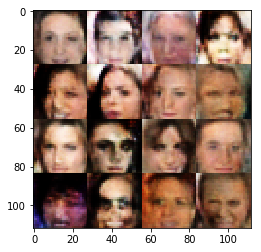

Epoch 0/1... Discriminator Loss: 0.7479... Generator Loss: 1.1776
Epoch 0/1... Discriminator Loss: 0.5717... Generator Loss: 1.8503
Epoch 0/1... Discriminator Loss: 0.9695... Generator Loss: 0.8820
Epoch 0/1... Discriminator Loss: 1.0083... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 0.5799... Generator Loss: 3.6192


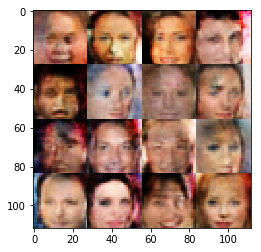

Epoch 0/1... Discriminator Loss: 0.4918... Generator Loss: 2.1882
Epoch 0/1... Discriminator Loss: 0.9318... Generator Loss: 0.9219
Epoch 0/1... Discriminator Loss: 2.6712... Generator Loss: 0.1683
Epoch 0/1... Discriminator Loss: 1.1473... Generator Loss: 0.6474
Epoch 0/1... Discriminator Loss: 0.9745... Generator Loss: 2.8268


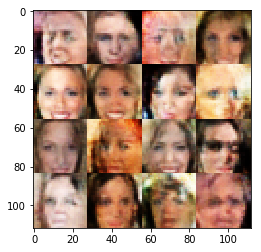

Epoch 0/1... Discriminator Loss: 0.6440... Generator Loss: 1.7224
Epoch 0/1... Discriminator Loss: 0.5865... Generator Loss: 1.8897
Epoch 0/1... Discriminator Loss: 0.5069... Generator Loss: 2.2061
Epoch 0/1... Discriminator Loss: 0.5952... Generator Loss: 1.6346
Epoch 0/1... Discriminator Loss: 0.4661... Generator Loss: 2.3984


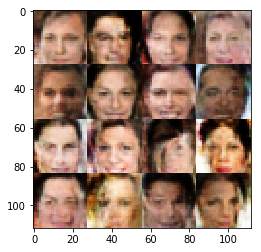

Epoch 0/1... Discriminator Loss: 0.8916... Generator Loss: 1.0245
Epoch 0/1... Discriminator Loss: 0.4761... Generator Loss: 2.7984
Epoch 0/1... Discriminator Loss: 1.9493... Generator Loss: 3.5630
Epoch 0/1... Discriminator Loss: 0.9834... Generator Loss: 2.9037
Epoch 0/1... Discriminator Loss: 0.7833... Generator Loss: 3.4610


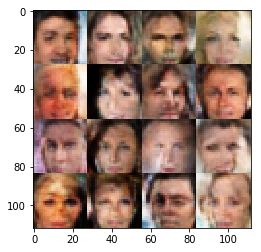

Epoch 0/1... Discriminator Loss: 0.5756... Generator Loss: 2.2627
Epoch 0/1... Discriminator Loss: 0.5451... Generator Loss: 1.8611
Epoch 0/1... Discriminator Loss: 1.1624... Generator Loss: 0.6607
Epoch 0/1... Discriminator Loss: 0.8153... Generator Loss: 1.1098
Epoch 0/1... Discriminator Loss: 0.5688... Generator Loss: 1.8069


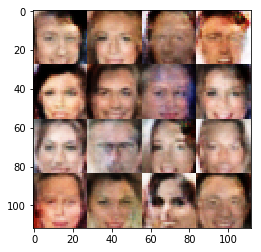

Epoch 0/1... Discriminator Loss: 2.4796... Generator Loss: 0.2021
Epoch 0/1... Discriminator Loss: 0.6365... Generator Loss: 1.7502
Epoch 0/1... Discriminator Loss: 0.4638... Generator Loss: 2.4134
Epoch 0/1... Discriminator Loss: 0.5090... Generator Loss: 2.8573
Epoch 0/1... Discriminator Loss: 0.7359... Generator Loss: 2.9443


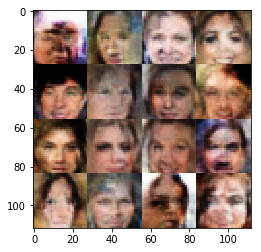

Epoch 0/1... Discriminator Loss: 1.2017... Generator Loss: 0.6240
Epoch 0/1... Discriminator Loss: 0.7864... Generator Loss: 2.8878
Epoch 0/1... Discriminator Loss: 1.7695... Generator Loss: 0.3611
Epoch 0/1... Discriminator Loss: 0.8051... Generator Loss: 1.2004
Epoch 0/1... Discriminator Loss: 0.7688... Generator Loss: 1.2145


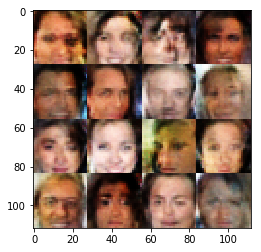

Epoch 0/1... Discriminator Loss: 0.6163... Generator Loss: 2.0730
Epoch 0/1... Discriminator Loss: 1.3663... Generator Loss: 0.5470
Epoch 0/1... Discriminator Loss: 2.0819... Generator Loss: 0.2602
Epoch 0/1... Discriminator Loss: 0.5155... Generator Loss: 2.2947
Epoch 0/1... Discriminator Loss: 0.7126... Generator Loss: 1.2925


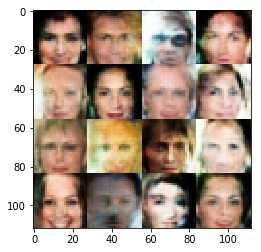

Epoch 0/1... Discriminator Loss: 0.6876... Generator Loss: 1.3452
Epoch 0/1... Discriminator Loss: 1.0019... Generator Loss: 0.8746
Epoch 0/1... Discriminator Loss: 0.7134... Generator Loss: 1.3582
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.0274
Epoch 0/1... Discriminator Loss: 1.0498... Generator Loss: 2.4315


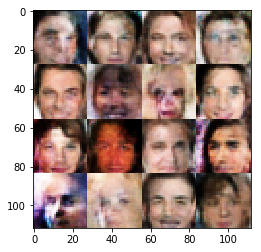

Epoch 0/1... Discriminator Loss: 0.7037... Generator Loss: 1.4529
Epoch 0/1... Discriminator Loss: 0.8464... Generator Loss: 1.1199
Epoch 0/1... Discriminator Loss: 0.8451... Generator Loss: 1.0700
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 0.9460
Epoch 0/1... Discriminator Loss: 0.8818... Generator Loss: 1.0587


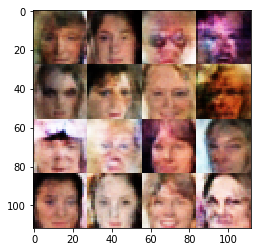

Epoch 0/1... Discriminator Loss: 0.5739... Generator Loss: 1.8876
Epoch 0/1... Discriminator Loss: 0.6140... Generator Loss: 1.6681
Epoch 0/1... Discriminator Loss: 1.5894... Generator Loss: 0.4526
Epoch 0/1... Discriminator Loss: 0.6466... Generator Loss: 3.3122
Epoch 0/1... Discriminator Loss: 1.1966... Generator Loss: 3.7542


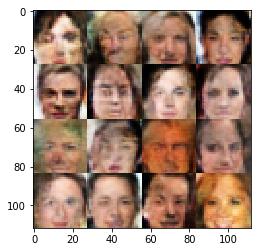

Epoch 0/1... Discriminator Loss: 1.0571... Generator Loss: 0.7769
Epoch 0/1... Discriminator Loss: 0.9489... Generator Loss: 4.2696
Epoch 0/1... Discriminator Loss: 0.5126... Generator Loss: 2.0365
Epoch 0/1... Discriminator Loss: 0.7466... Generator Loss: 2.3818
Epoch 0/1... Discriminator Loss: 0.4234... Generator Loss: 3.0133


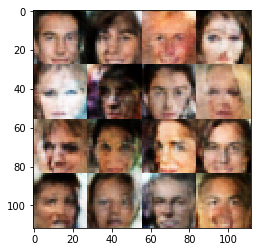

Epoch 0/1... Discriminator Loss: 1.0293... Generator Loss: 2.1300
Epoch 0/1... Discriminator Loss: 0.8469... Generator Loss: 1.1198
Epoch 0/1... Discriminator Loss: 0.5011... Generator Loss: 2.3452
Epoch 0/1... Discriminator Loss: 0.5073... Generator Loss: 2.1643
Epoch 0/1... Discriminator Loss: 1.0519... Generator Loss: 1.5640


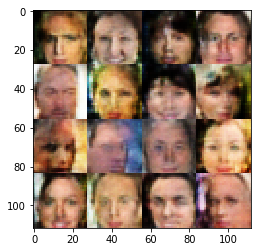

Epoch 0/1... Discriminator Loss: 1.0508... Generator Loss: 0.7385
Epoch 0/1... Discriminator Loss: 0.7542... Generator Loss: 1.3392
Epoch 0/1... Discriminator Loss: 0.7864... Generator Loss: 1.1914
Epoch 0/1... Discriminator Loss: 0.8586... Generator Loss: 3.5180
Epoch 0/1... Discriminator Loss: 0.7092... Generator Loss: 1.5053


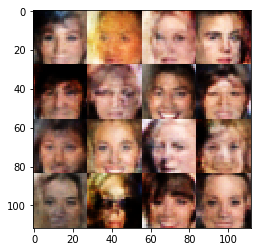

Epoch 0/1... Discriminator Loss: 0.5785... Generator Loss: 2.1667
Epoch 0/1... Discriminator Loss: 0.7804... Generator Loss: 1.7342
Epoch 0/1... Discriminator Loss: 1.6284... Generator Loss: 0.4027
Epoch 0/1... Discriminator Loss: 0.5742... Generator Loss: 2.2336
Epoch 0/1... Discriminator Loss: 0.6864... Generator Loss: 2.0851


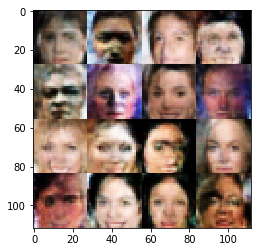

Epoch 0/1... Discriminator Loss: 0.9734... Generator Loss: 3.0122
Epoch 0/1... Discriminator Loss: 1.1485... Generator Loss: 2.7919
Epoch 0/1... Discriminator Loss: 0.6766... Generator Loss: 1.3660
Epoch 0/1... Discriminator Loss: 0.7735... Generator Loss: 3.3592
Epoch 0/1... Discriminator Loss: 1.0428... Generator Loss: 0.7617


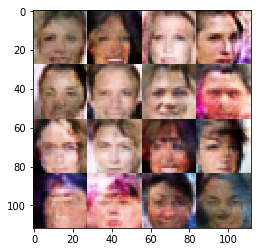

Epoch 0/1... Discriminator Loss: 0.7708... Generator Loss: 2.0297
Epoch 0/1... Discriminator Loss: 1.1453... Generator Loss: 3.3177
Epoch 0/1... Discriminator Loss: 0.7028... Generator Loss: 1.9681
Epoch 0/1... Discriminator Loss: 0.7468... Generator Loss: 2.8695
Epoch 0/1... Discriminator Loss: 1.6390... Generator Loss: 0.3802


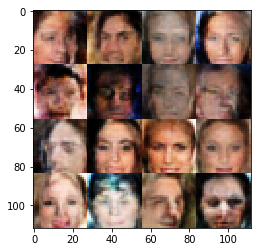

Epoch 0/1... Discriminator Loss: 0.6468... Generator Loss: 1.5651
Epoch 0/1... Discriminator Loss: 0.9856... Generator Loss: 0.8509
Epoch 0/1... Discriminator Loss: 0.6691... Generator Loss: 2.6734
Epoch 0/1... Discriminator Loss: 1.0988... Generator Loss: 0.8197
Epoch 0/1... Discriminator Loss: 0.6190... Generator Loss: 2.7529


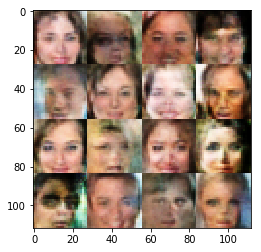

Epoch 0/1... Discriminator Loss: 0.9510... Generator Loss: 0.8408
Epoch 0/1... Discriminator Loss: 1.8949... Generator Loss: 4.0987
Epoch 0/1... Discriminator Loss: 1.1132... Generator Loss: 0.7461
Epoch 0/1... Discriminator Loss: 0.5154... Generator Loss: 2.0987
Epoch 0/1... Discriminator Loss: 1.1836... Generator Loss: 0.6712


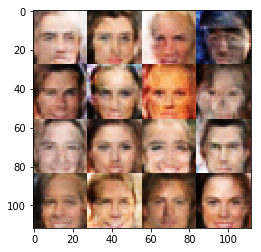

Epoch 0/1... Discriminator Loss: 1.0023... Generator Loss: 0.7923
Epoch 0/1... Discriminator Loss: 0.5561... Generator Loss: 2.3995
Epoch 0/1... Discriminator Loss: 0.5589... Generator Loss: 1.9076
Epoch 0/1... Discriminator Loss: 1.2098... Generator Loss: 2.9858
Epoch 0/1... Discriminator Loss: 0.5845... Generator Loss: 1.8676


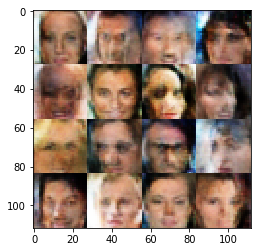

Epoch 0/1... Discriminator Loss: 0.7947... Generator Loss: 1.1785
Epoch 0/1... Discriminator Loss: 0.5085... Generator Loss: 2.2903
Epoch 0/1... Discriminator Loss: 0.6080... Generator Loss: 2.4341
Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 3.7637
Epoch 0/1... Discriminator Loss: 1.4489... Generator Loss: 0.4938


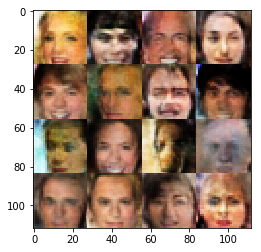

Epoch 0/1... Discriminator Loss: 1.2473... Generator Loss: 0.6559
Epoch 0/1... Discriminator Loss: 0.5240... Generator Loss: 2.2692
Epoch 0/1... Discriminator Loss: 0.7482... Generator Loss: 4.0581
Epoch 0/1... Discriminator Loss: 0.4506... Generator Loss: 2.5928
Epoch 0/1... Discriminator Loss: 0.9239... Generator Loss: 2.3686


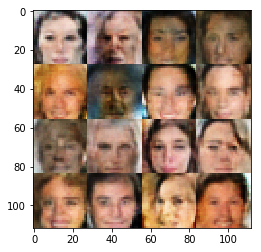

Epoch 0/1... Discriminator Loss: 1.2385... Generator Loss: 1.9021
Epoch 0/1... Discriminator Loss: 0.7157... Generator Loss: 1.3891
Epoch 0/1... Discriminator Loss: 0.7513... Generator Loss: 1.2786
Epoch 0/1... Discriminator Loss: 0.8688... Generator Loss: 1.0257
Epoch 0/1... Discriminator Loss: 0.6376... Generator Loss: 1.8286


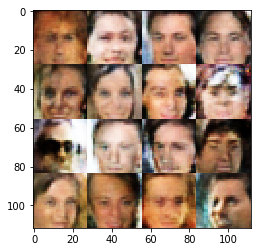

Epoch 0/1... Discriminator Loss: 0.6342... Generator Loss: 1.5987
Epoch 0/1... Discriminator Loss: 0.7126... Generator Loss: 1.3607
Epoch 0/1... Discriminator Loss: 0.6215... Generator Loss: 1.7033
Epoch 0/1... Discriminator Loss: 0.8887... Generator Loss: 2.1474
Epoch 0/1... Discriminator Loss: 0.5018... Generator Loss: 2.3363


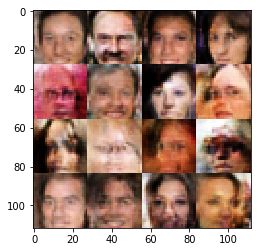

Epoch 0/1... Discriminator Loss: 3.4651... Generator Loss: 5.7804
Epoch 0/1... Discriminator Loss: 0.5348... Generator Loss: 2.0443
Epoch 0/1... Discriminator Loss: 0.9276... Generator Loss: 2.6969
Epoch 0/1... Discriminator Loss: 0.9121... Generator Loss: 0.9474
Epoch 0/1... Discriminator Loss: 1.0348... Generator Loss: 0.7683


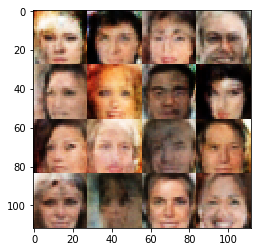

Epoch 0/1... Discriminator Loss: 0.5541... Generator Loss: 2.6652
Epoch 0/1... Discriminator Loss: 0.4677... Generator Loss: 2.5390
Epoch 0/1... Discriminator Loss: 0.5641... Generator Loss: 1.8124
Epoch 0/1... Discriminator Loss: 0.7398... Generator Loss: 1.3029
Epoch 0/1... Discriminator Loss: 0.7839... Generator Loss: 1.2800


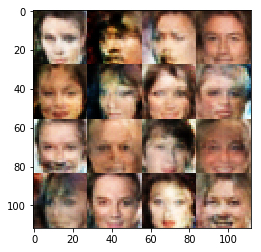

Epoch 0/1... Discriminator Loss: 0.9430... Generator Loss: 0.8801
Epoch 0/1... Discriminator Loss: 0.4734... Generator Loss: 2.6805
Epoch 0/1... Discriminator Loss: 2.3426... Generator Loss: 0.1759
Epoch 0/1... Discriminator Loss: 0.5306... Generator Loss: 1.9440
Epoch 0/1... Discriminator Loss: 0.4724... Generator Loss: 2.4915


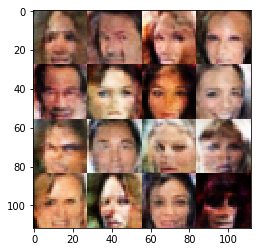

Epoch 0/1... Discriminator Loss: 0.9228... Generator Loss: 0.9593
Epoch 0/1... Discriminator Loss: 0.7147... Generator Loss: 1.3542
Epoch 0/1... Discriminator Loss: 0.6728... Generator Loss: 2.0024
Epoch 0/1... Discriminator Loss: 0.9309... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 0.6034... Generator Loss: 1.7186


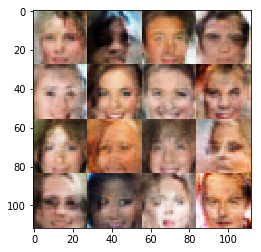

Epoch 0/1... Discriminator Loss: 2.6059... Generator Loss: 5.0734
Epoch 0/1... Discriminator Loss: 1.0165... Generator Loss: 1.1532
Epoch 0/1... Discriminator Loss: 0.7073... Generator Loss: 1.5869
Epoch 0/1... Discriminator Loss: 0.6743... Generator Loss: 1.6208
Epoch 0/1... Discriminator Loss: 0.6728... Generator Loss: 3.0313


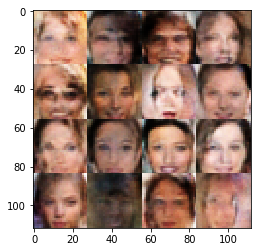

Epoch 0/1... Discriminator Loss: 1.1766... Generator Loss: 0.6973
Epoch 0/1... Discriminator Loss: 1.1261... Generator Loss: 0.6879
Epoch 0/1... Discriminator Loss: 0.7285... Generator Loss: 1.2393
Epoch 0/1... Discriminator Loss: 0.8497... Generator Loss: 1.0835


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.